In [70]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from itertools import count
from collections import namedtuple, deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Initializing logging

In [157]:
import logging
import sys

# Create a custom log formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Configure logging with custom format and file output
logging.basicConfig(filename='./logs/app.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Example log messages
logging.debug("This is a debug message")
logging.info("This is an info message")
logging.warning("This is a warning message")
logging.error("This is an error message")
logging.critical("This is a critical message")

In [158]:
filename = "EURUSD_M1_2023.csv"

df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
# data = df.resample('5min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

df = df.iloc[:100]

data = df.copy()
#Drop NA rows
data = data.dropna(axis=0)

print(data.head(10))
print(data.describe())

                        open     high      low    close
timestamp                                              
2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
             open        high         low       close
count  100.000000  100.000000  100.000000  100.000000
mean     1.069493    1.069675    1.069319    1.069319
std      0.000472    0.000491    0.000505    0.000505
min      1.067880    1.067880    1.067880    1.067880
25%      1.069387    1.069507    1.068998    1.068998
50% 

In [159]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Env

In [143]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

import random



class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(Enum):
    Short = 0
    Long = 1
    Hold = 2

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        # self._position = Positions.Short
        self._position = self.get_position(seed)
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        # print("Updating profit")

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )
    #return a random position
    def get_position(seed=None):
        if seed is not None:
            random.seed(seed)

        return random.choice(list(Positions))

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        print("Rendring....")

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError


In [150]:
import numpy as np

# from .TradingEnv import TradingEnv, Actions, Positions


class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left', render_mode=None):
        print("init forex env.")
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size, render_mode)

        self.trade_fee = 0.0003  # unit

    def _process_data(self):
        prices = self.df.loc[:, 'close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        step_reward = 0  # pip

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Short:
                step_reward += -price_diff * 10000
            elif self._position == Positions.Long:
                step_reward += price_diff * 10000

        return step_reward

    def _update_profit(self, action):
        trade = False
        print("Updating profit with action: ",action)

        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit


In [152]:
from envs import ForexEnv, Actions


window_size = 10
start_index = window_size
end_index = len(data)
# len(data)

env  = ForexEnv(
    df= data,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [153]:
from stable_baselines3 import DQN
import torch.optim as optim

learning_rate = 0.01
optimizer = optim.Adam

model = DQN(
    "MlpPolicy",
    env = env,
    buffer_size=10000, 
    batch_size = 32,
    train_freq = 32,
    gradient_steps = 32,
    target_update_interval = 32,
    learning_rate=learning_rate,
    verbose=1,
    device=device,
)
model.learn(total_timesteps=1000, log_interval=4)

### Fine tuning with adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# model.save("dqn_stable_baseline3_eurusd_2023_5M")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_stable_baseline3_eurusd_2023_5M")

model

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4944     |
|    time_elapsed     | 0        |
|    total_timesteps  | 356      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5048     |
|    time_elapsed     | 0        |
|    total_timesteps  | 712      |
----------------------------------


In [154]:

#initial state
action_stats = {Actions.Sell: 0, Actions.Buy: 0,}

observation, info = env.reset()

episode = 100
for i in range(episode):
    action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
# print("Trades:", env.unwrapped.)


action_stats: {<Actions.Sell: 0>: 3, <Actions.Buy: 1>: 86}
info: {'total_reward': -8.699893951416016, 'total_profit': 0.9974863403731475, 'position': <Positions.Long: 1>}


In [130]:
model.save("dqn_stable_baseline3_eurusd_2023_1M")

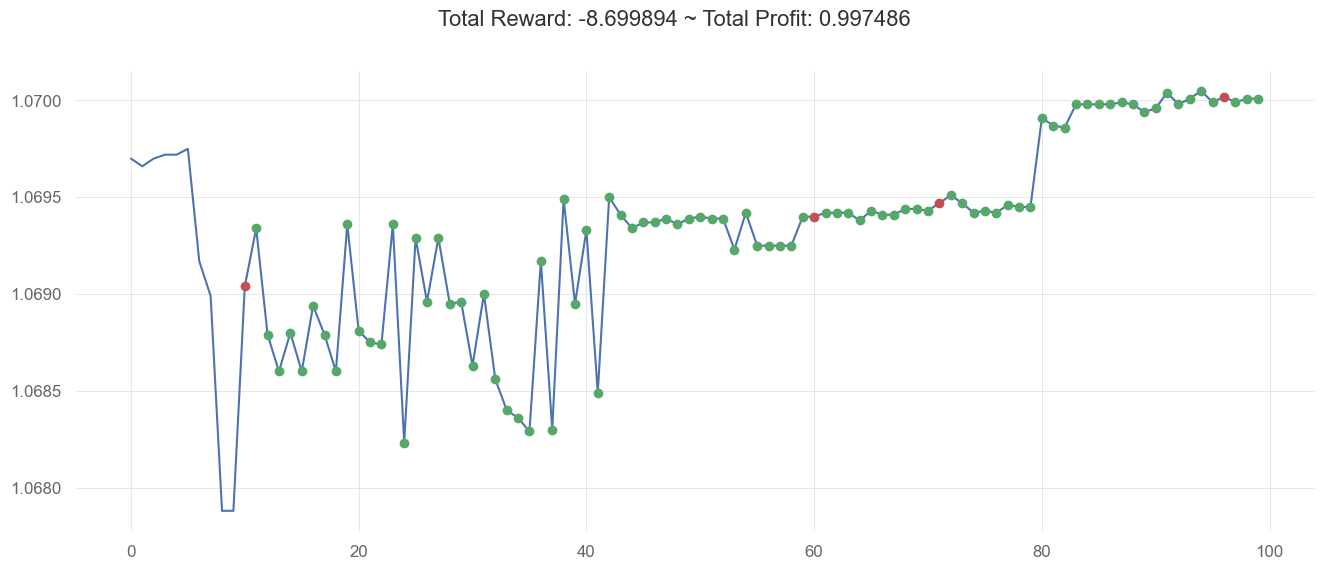

In [155]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [132]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns)

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')

ValueError: Length of values (10) does not match length of index (89)